In [27]:
import torch

torch.manual_seed(1)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

# Initialization

## Glorot/Xavier init

In [2]:
def lin(x, w, b): return x @ w + b

In [3]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is `nan`s everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problemâ€”the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [4]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [5]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:5,0:5]

tensor([[-2.0402,  0.4571,  0.9591,  1.0719,  0.1009],
        [ 1.8356, -1.1056, -0.6510, -0.2354, -0.3940],
        [ 1.3441, -0.5651, -0.3308, -0.7280, -0.4035],
        [-1.5553,  0.3304,  1.2735,  0.1515, -0.7188],
        [-0.3758,  0.4064, -0.0553,  0.1119, -0.7302]])

## Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g.:

In [ ]:
t = torch.tensor([1.,2.,4.,18])

In [ ]:
m = t.mean(); m

tensor(6.2500)

In [ ]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [ ]:
(t-m).pow(2).mean()

tensor(47.1875)

In [ ]:
(t-m).abs().mean()

tensor(5.8750)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [ ]:
(t-m).pow(2).mean().sqrt()

tensor(6.8693)

They're still different. Why?

Note that we have one outlier (`18`). In the version where we square everything, it makes that much bigger than everything else.

`(t-m).pow(2).mean()` is refered to as **variance**. It's a measure of how spread out the data is, and is particularly sensitive to outliers.

When we take the sqrt of the variance, we get the **standard deviation**. Since it's on the same kind of scale as the original data, it's generally more interpretable. However, since `sqrt(1)==1`, it doesn't much matter which we use when talking about *unit variance* for initializing neural nets.

The standard deviation represents if the data stays close to the mean or on the contrary gets values that are far away. It's computed by the following formula:

$$\sigma = \sqrt{\frac{1}{n}\left[(x_{0}-m)^{2} + (x_{1}-m)^{2} + \cdots + (x_{n-1}-m)^{2}\right]}$$

where m is the mean and $\sigma$ (the greek letter sigma) is the standard deviation. Here we have a mean of 0, so it's just the square root of the mean of x squared.

`(t-m).abs().mean()` is referred to as the **mean absolute deviation**. It isn't used nearly as much as it deserves to be, because mathematicians don't like how awkward it is to work with. But that shouldn't stop us, because we have computers and stuff.

Here's a useful thing to note about variance:

In [ ]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.1875), tensor(47.1875))

You can see why these are equal if you want to work thru the algebra. Or not.

But, what's important here is that the latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences).

Let's go steal the LaTeX from [Wikipedia](https://en.wikipedia.org/wiki/Variance):

$$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Here's how Wikipedia defines covariance:

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

In [ ]:
t

tensor([ 1.,  2.,  4., 18.])

Let's see that in code. So now we need two vectors.

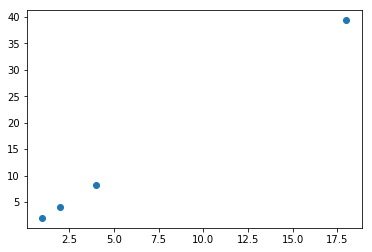

In [ ]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [ ]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 59.8856,  39.8543,  11.6089, 304.8394])

In [ ]:
prod.mean()

tensor(104.0471)

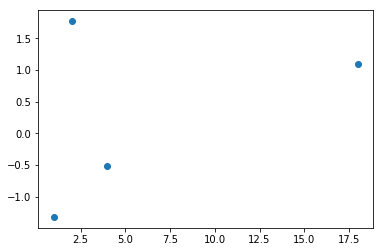

In [ ]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [ ]:
((t-t.mean())*(v-v.mean())).mean()

tensor(3.3606)

It's generally more conveniently defined like so:

$$\operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right] \operatorname{E}\left[Y\right]$$

In [ ]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(3.3606)

From now on, you're not allowed to look at an equation (or especially type it in LaTeX) without also typing it in Python and actually calculating some values. Ideally, you should also plot some values.

Finally, here is the Pearson correlation coefficient:

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [ ]:
cov / (t.std() * v.std())

tensor(0.2978)

It's just a scaled version of the same thing. Question: *Why is it scaled by standard deviation, and not by variance or mean or something else?*

In [6]:
x.std()

tensor(0.9965)

### Xavier init derivation

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since we picked it that way).

In [18]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(-0.0339), tensor(0.9507))

If we go back to `y = a @ x` and assume that we chose weights for `a` that also have a mean of 0, we can compute the standard deviation of `y` quite easily. Since it's random, and we may fall on bad numbers, we repeat the operation 100 times.

In [19]:
mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.005886524803936481, 99.76581344604492)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in `a` and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [20]:
mean,sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000,sqr/10000

(0.010153415262380986, 1.0308116454562741)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a `y` of scale 1, and repeating the product has many times as we want won't overflow or vanish.

## He init

("He" is a Chinese surname and is pronouced like "Her", not like "Hee".)

In [21]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [22]:
from math import sqrt
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [23]:
l1 = lin(x, w1, b1)
l1.mean(),l1.std()

(tensor(-0.0064), tensor(1.0063))

In [24]:
def relu(x): return x.clamp_min(0.)

In [25]:
l2 = relu(l1)
l2.mean(),l2.std()

(tensor(0.3978), tensor(0.5848))

In [28]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5,0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In ["Delving Deep into Rectifiers: Surpassing Human-Level Performance"](https://arxiv.org/abs/1502.01852) Kaiming He et al. show that we should use the following scale instead: $\sqrt{2 / n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [29]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.00, 0.60, 0.00, 0.00, 0.41],
        [0.00, 1.06, 0.00, 0.00, 0.53],
        [0.00, 1.11, 0.00, 0.00, 0.59],
        [0.00, 0.42, 0.00, 0.00, 0.23],
        [0.00, 1.34, 0.00, 0.00, 0.79]])

In [15]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [16]:
w1 = torch.randn(100,50) * sqrt(2 / 100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) * sqrt(2 / 50)
b2 = torch.zeros(1)

In [17]:
l1 = lin(x, w1, b1)
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.5706), tensor(0.8259))